In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression 
import matplotlib.pylab as pylab
import math,time
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout, Activation
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# split data in 60%/20%/20% train/validation/test sets
valid_set_size_percentage = 20 
test_set_size_percentage = 20 

from pandas import read_csv
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

Using TensorFlow backend.


In [2]:
df = read_csv('dataset/Iron ore fines 62% Fe CFR Futures Historical Data.csv')

In [3]:
df = df.drop(['Vol.', 'Change %'], axis=1)

In [4]:
s = 0
l = 714
for i in range(round(len(df)/2)):
    s_temp = df.iloc[s].copy()
    l_temp = df.iloc[l].copy()
    df.iloc[s] = l_temp
    df.iloc[l] = s_temp
    s = s + 1
    l = l -1

In [5]:
from dateutil import parser
for i in range(len(df['Date'])):
    dt = parser.parse(df['Date'][i])
    df['Date'][i] = dt.strftime("%Y-%m-%d")
    #print(train['Date'][i], i)
df = df.set_index('Date')

C:\Users\sumon\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [6]:
# import plotly
# plotly.tools.set_credentials_file(username='sumon23', api_key='zqTb8KrZdBd7cVBAUPk4')

In [7]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

#plot(data)

price = go.Scatter(
                x=df.index,
                y=df['Price'],
                name = "Price",
                line = dict(color = 'red') 
               # opacity = 0.2
                )

open_price = go.Scatter(
                x=df.index,
                y=df['Open'],
                name = "Open",
                line = dict(color = 'green')
                #opacity = 0.8
                )
high_price = go.Scatter(
                x=df.index,
                y=df['High'],
                name = "High",
                line =  dict(color = 'blue')
                #opacity = 0.8
                )

low_price = go.Scatter(
                x=df.index,
                y=df['Low'],
                name = "Low",
                line =  dict(color = 'black')
                #opacity = 0.8
                )
data = [price,open_price,high_price,low_price]

layout = go.Layout(title='Iron Ore Price', xaxis=dict(title='Date'),
                   yaxis=dict(title='(Price)'))
#fig = go.Figure(data=[data], layout=layout)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "Irn Ore Price")

C:\Users\sumon\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [8]:
# Significant coorelation between lags 
# acf = plot_acf(df['Open'], lags = 20)
# No significant pattern in pacf
# pacf = plot_pacf(df['Open'], lags = 20)

In [9]:
#w = 20 # define window size

In [10]:
# roll_df = df.rolling(window=w).mean() #20 row avg
# roll_df.dropna(inplace=True)
# roll_df.describe()

In [11]:
start = min(df.index.tolist())
end = max(df.index.tolist())
print("Start date: ", start, ", End date: ", end)
df.head()

Start date:  2016-01-04 , End date:  2018-10-16


,Price,Open,High,Low
Date,,,,
2016-01-04,41.70,41.70,43.10,37.80
2016-01-05,41.52,41.52,42.75,37.25
2016-01-06,40.92,40.92,41.55,36.00
2016-01-07,40.95,40.95,41.00,33.30
2016-01-08,40.62,40.62,41.10,33.20


In [12]:
# function for min-max normalization of Iron Ore 
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
def normalize_data(df):
    df['Price'] = min_max_scaler.fit_transform(df.Price.values.reshape(-1,1))
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    return df

In [13]:
# normalize stock
df_norm = df.copy()
df_norm = normalize_data(df_norm)
df_norm

,Price,Open,High,Low
Date,,,,
2016-01-04,0.043804,0.043804,0.061815,0.081705
2016-01-05,0.040253,0.040253,0.054835,0.071936
2016-01-06,0.028414,0.028414,0.030907,0.049734
2016-01-07,0.029006,0.029006,0.019940,0.001776
2016-01-08,0.022494,0.022494,0.021934,0.000000
2016-01-11,0.009866,0.009866,0.013958,0.001776
2016-01-12,0.000000,0.000000,0.000000,0.014210
2016-01-13,0.007893,0.007893,0.000000,0.014210
2016-01-14,0.012826,0.012826,0.007976,0.021314


In [14]:
# # function to create train, validation, test data given stock data and sequence length
# def load_data(stock, seq_len):
#     data_raw = stock.as_matrix() # convert to numpy array shape (715,4)
#     print(data_raw.shape)
#     data = []
#     cnt = 0
#     # create all possible sequences of length seq_len
#     for index in range(len(data_raw) - seq_len): 
#         data.append(data_raw[index: index + seq_len])
    
    
#     data = np.array(data);
#     print(data.shape)
#     valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
#     test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
#     train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
#     x_train = data[:train_set_size,:-1,:]
#     y_train = data[:train_set_size,-1,:] #take the last row from every 20 steps
#     #y_train = data[:,-1][:,-1]
#     x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
  
#     y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
#     x_test = data[train_set_size+valid_set_size:,:-1,:]
#     y_test = data[train_set_size+valid_set_size:,-1,:]
    
#     return [x_train, y_train, x_valid, y_valid, x_test, y_test]

In [15]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) # 4
    print(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    print("result shape: ", result.shape)
    row = round(0.9 * result.shape[0]) # 90% split
    print("row: ",row)
    train = result[:int(row), :] # 90% date, all features 
    print("train shape: ",train.shape)
    x_train = train[:, :-1] 
    print("x_train shape: ",train[0].shape)
    #print(train[1])
    y_train = train[:, -1][:,0] #take only price value from every 23 row
    #print(y_train)
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,0]
    #Reshape data for (Sample,Timestep,Features)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [16]:
# create train, test data
seq_len = 22 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

Index(['Price', 'Open', 'High', 'Low'], dtype='object')
result shape:  (692, 23, 4)
row:  623
train shape:  (623, 23, 4)
x_train shape:  (23, 4)
x_train.shape =  (623, 22, 4)
y_train.shape =  (623,)
x_test.shape =  (69, 22, 4)
y_test.shape =  (69,)


C:\Users\sumon\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [17]:
# Choose only  Prices column
# x_train, y_train, x_valid, y_valid, x_test, y_test = x_train[:,:,0], y_train[:,0], x_valid[:,:,0], y_valid[:,0], x_test[:,:,0], y_test[:,0]
# print('x_train.shape = ',x_train.shape)
# print('y_train.shape = ', y_train.shape)
# print('x_valid.shape = ',x_valid.shape)
# print('y_valid.shape = ', y_valid.shape)
# print('x_test.shape = ', x_test.shape)
# print('y_test.shape = ',y_test.shape)

In [18]:
#Reshape data for (Sample,Timestep,Features) 
# x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],1))
# x_valid = x_valid.reshape((x_valid.shape[0],x_valid.shape[1],1))
# x_test = x_test.reshape((x_test.shape[0],x_test.shape[1],1))

In [19]:
print("Build model")
def build_model(layers):
    print(layers[2])
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

Build model


In [20]:
print(x_train[0],y_train[0])

[[0.04380426 0.04380426 0.06181456 0.08170515]
 [0.04025257 0.04025257 0.05483549 0.07193606]
 [0.02841358 0.02841358 0.03090728 0.04973357]
 [0.02900552 0.02900552 0.01994018 0.0017762 ]
 [0.02249408 0.02249408 0.0219342  0.        ]
 [0.00986582 0.00986582 0.01395813 0.0017762 ]
 [0.         0.         0.         0.01420959]
 [0.00789266 0.00789266 0.         0.01420959]
 [0.01282557 0.01282557 0.00797607 0.02131439]
 [0.0191397  0.0191397  0.01196411 0.03996448]
 [0.04577743 0.04577743 0.04985045 0.08081705]
 [0.04005525 0.04005525 0.03788634 0.09680284]
 [0.02466456 0.02466456 0.02991027 0.13499112]
 [0.02841358 0.02841358 0.03489531 0.15186501]
 [0.03137332 0.03137332 0.02133599 0.13978686]
 [0.02920284 0.02920284 0.02791625 0.11190053]
 [0.03058406 0.03058406 0.01894317 0.13765542]
 [0.03295185 0.03295185 0.02492522 0.14298401]
 [0.0335438  0.0335438  0.02352941 0.14174067]
 [0.03334649 0.03334649 0.02333001 0.14156306]
 [0.0753749  0.0753749  0.06979063 0.1660746 ]
 [0.08070245 

In [21]:
model = build_model([4,seq_len,1])

1
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Compilation Time :  0.022937774658203125


In [22]:
model.fit(x_train,y_train,batch_size=1,epochs=20,validation_split=0.1,verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 560 samples, validate on 63 samples
Epoch 1/20
560/560 [==============================] - 23s 41ms/step - loss: 0.0506 - acc: 0.0000e+00 - val_loss: 0.0023 - val_acc: 0.0000e+00
Epoch 2/20
560/560 [==============================] - 22s 39ms/step - loss: 0.0143 - acc: 0.0018 - val_loss: 9.3114e-04 - val_acc: 0.0000e+00
Epoch 3/20
560/560 [==============================] - 21s 38ms/step - loss: 0.0062 - acc: 0.0018 - val_loss: 3.0937e-04 - val_acc: 0.0000e+00
Epoch 4/20
560/560 [==============================] - 21s 38ms/step - loss: 0.0054 - acc: 0.0018 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 5/20
560/560 [==============================] - 21s 38ms/step - loss: 0.0051 - acc: 0.0018 - val_loss: 0.0022 - val_acc: 0.0000e+00
Epoch 6/20
560/560 [==============================] - 21s 38ms/step - loss: 0.0063 - acc: 0.0018 - val_loss: 6.4381e-04 - val_acc: 0.0000e+00
Epoch 7/20
560/560 [==============================] - 22s 39ms/

In [23]:
pred_price = model.predict(x_test,batch_size=1,verbose=1)

69/69 [==============================] - 1s 8ms/step


In [24]:
df.head()

,Price,Open,High,Low
Date,,,,
2016-01-04,41.70,41.70,43.10,37.80
2016-01-05,41.52,41.52,42.75,37.25
2016-01-06,40.92,40.92,41.55,36.00
2016-01-07,40.95,40.95,41.00,33.30
2016-01-08,40.62,40.62,41.10,33.20


In [26]:
df['Price'].shape

(715,)

In [27]:
def denormalize(df, normalized_value): 
    df = df['Price'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    #return df.shape, p.shape
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(df, pred_price)
newy_test = denormalize(df, y_test)

In [28]:
def model_score(model, x_train, y_train, x_test, y_test):
    trainScore = model.evaluate(x_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(x_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]


model_score(model, x_train, y_train, x_test, y_test)

Train Score: 0.00209 MSE (0.05 RMSE)
Test Score: 0.00160 MSE (0.04 RMSE)


(0.0020906481878603263, 0.0015957206757604213)

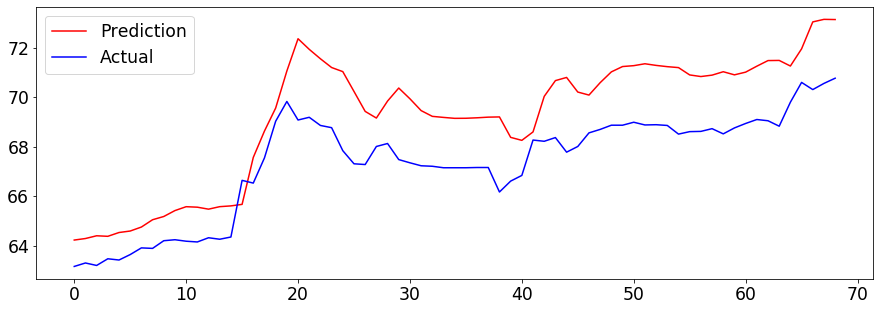

In [33]:
plt.figure(figsize=(15, 5));
plt.plot(newp,color='red', label='Prediction')
plt.plot(newy_test,color='blue', label='Actual')
plt.legend(loc='best')
plt.show()

In [1]:
import pandas as pd
act_pred = pd.concat([pd.DataFrame(newp), pd.DataFrame(newy_test)], axis=1)
act_pred.columns = ['Predicted', 'Actual']

NameError: name 'newp' is not defined

In [ ]:
act_pred

In [32]:
df.Price

Date
2016-01-04    41.70
2016-01-05    41.52
2016-01-06    40.92
2016-01-07    40.95
2016-01-08    40.62
2016-01-11    39.98
2016-01-12    39.48
2016-01-13    39.88
2016-01-14    40.13
2016-01-15    40.45
2016-01-18    41.80
2016-01-19    41.51
2016-01-20    40.73
2016-01-21    40.92
2016-01-22    41.07
2016-01-25    40.96
2016-01-26    41.03
2016-01-27    41.15
2016-01-28    41.18
2016-01-29    41.17
2016-02-02    43.30
2016-02-03    43.57
2016-02-04    44.25
2016-02-05    44.05
2016-02-08    44.25
2016-02-09    43.75
2016-02-10    43.19
2016-02-11    43.00
2016-02-12    43.00
2016-02-15    44.69
              ...  
2018-09-05    66.84
2018-09-06    68.27
2018-09-07    68.22
2018-09-10    68.37
2018-09-11    67.78
2018-09-12    68.01
2018-09-13    68.56
2018-09-14    68.70
2018-09-17    68.87
2018-09-18    68.87
2018-09-19    68.99
2018-09-20    68.88
2018-09-21    68.89
2018-09-24    68.86
2018-09-25    68.51
2018-09-26    68.61
2018-09-27    68.62
2018-09-28    68.73
2018-10-01    6

In [ ]:
# # Visualise predictions
# pred_price = model.predict(x_test)
# plt.figure(figsize=(15, 5));
# plt.plot( np.arange(y_test.shape[0]), min_max_scaler.inverse_transform(y_test.reshape(-1,1)),label='Original')
# plt.plot(np.arange(y_test.shape[0]), min_max_scaler.inverse_transform(pred_price), label ='Predictions')
# plt.xlabel('Days')
# plt.ylabel('Price')
# plt.legend(loc='best')
# plt.show()

In [ ]:
len(pred_price)

In [ ]:
len(y_test)

In [ ]:
x = [[1,2,3,4],[9,5,6,7],[10,11,12,13]]

In [ ]:
x

In [ ]:
y_train = x[:,-1]